# Low-Rank Approximation with SVD

This notebook demonstrates low-rank matrix approximation using Singular Value Decomposition (SVD) for image compression. We'll explore how different rank approximations affect image quality and storage requirements.


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.datasets import load_sample_image


## Image Loading

Load the image from disk or use a sample image as fallback. We'll work with grayscale images to simplify the analysis.


In [15]:
# Try loading a local image first
image_path = "images/tolu.jpg"

if os.path.exists(image_path):
    # Load image from disk
    img = Image.open(image_path)
    print(f"Loaded image: {img.size[0]}×{img.size[1]}, mode={img.mode}")

    # Working in grayscale keeps things easier to reason about
    if img.mode != "L":
        img_gray = img.convert("L")
    else:
        img_gray = img

    image_array = np.array(img_gray, dtype=np.float32) / 255.0
    original_size_bytes = os.path.getsize(image_path)

else:
    # Fall back to a standard sample image if the file isn't found
    print(f"Image not found at '{image_path}'. Using a sample flower image instead.")

    flower = load_sample_image("flower.jpg")
    img_gray = Image.fromarray(flower).convert("L")

    image_array = np.array(img_gray, dtype=np.float32) / 255.0
    original_size_bytes = image_array.size  # rough proxy for raw size


Loaded image: 1920×2560, mode=RGB


## Image Properties

Display basic properties of the loaded image, including its dimensions, matrix rank, and storage size.


In [16]:
print(f"Image array shape: {image_array.shape}")
print(f"Matrix rank: {np.linalg.matrix_rank(image_array)}")
print(f"Approx. original size: {original_size_bytes/1024:.1f} KB")


Image array shape: (2560, 1920)
Matrix rank: 538
Approx. original size: 240.0 KB


## Singular Value Decomposition

Perform SVD on the image matrix. This decomposes the image into three matrices: U (left singular vectors), S (singular values), and Vt (right singular vectors transposed).


In [17]:
# Singular Value Decomposition
U, S, Vt = np.linalg.svd(image_array, full_matrices=False)

BYTES_PER_VALUE = 4  # assuming float32 storage
m, n = image_array.shape
original_pixels = m * n
original_raw_bytes = original_pixels * BYTES_PER_VALUE


## Storage Calculation Function

Define a helper function to calculate the storage requirements for a rank-k approximation. For a rank-k approximation, we need to store:
- U: m × k matrix
- k singular values
- V: n × k matrix


In [18]:
def svd_storage(k, m, n, bytes_per_value=4):
    """
    Storage required for a rank-k approximation.

    We keep:
    - U: m × k
    - singular values: k
    - V: n × k
    """
    total_values = k * (m + n + 1)
    return total_values, total_values * bytes_per_value


## Low-Rank Approximations

Reconstruct the image using different rank approximations and visualize the results. For each rank k, we:
- Reconstruct the image using only the first k singular components
- Calculate compression ratio and storage requirements
- Compute quality metrics (PSNR, energy retained)


In [19]:
print("\n" + "=" * 70)
print("LOW-RANK APPROXIMATIONS")
print("=" * 70)

ranks_to_test = [1, 5, 10, 20, 30, 50, 100, 150, 200]



LOW-RANK APPROXIMATIONS


Rank   5 | Storage:   87.5 KB | Compression: 219.4× | Energy kept: 98.69% | PSNR:  21.8 dB
Rank  10 | Storage:  175.0 KB | Compression: 109.7× | Energy kept: 99.21% | PSNR:  24.0 dB
Rank  20 | Storage:  350.1 KB | Compression:  54.8× | Energy kept: 99.59% | PSNR:  26.8 dB
Rank  30 | Storage:  525.1 KB | Compression:  36.6× | Energy kept: 99.74% | PSNR:  28.8 dB
Rank  50 | Storage:  875.2 KB | Compression:  21.9× | Energy kept: 99.86% | PSNR:  31.5 dB
Rank 100 | Storage: 1750.4 KB | Compression:  11.0× | Energy kept: 99.94% | PSNR:  35.5 dB
Rank 150 | Storage: 2625.6 KB | Compression:   7.3× | Energy kept: 99.97% | PSNR:  38.2 dB
Rank 200 | Storage: 3500.8 KB | Compression:   5.5× | Energy kept: 99.98% | PSNR:  40.5 dB


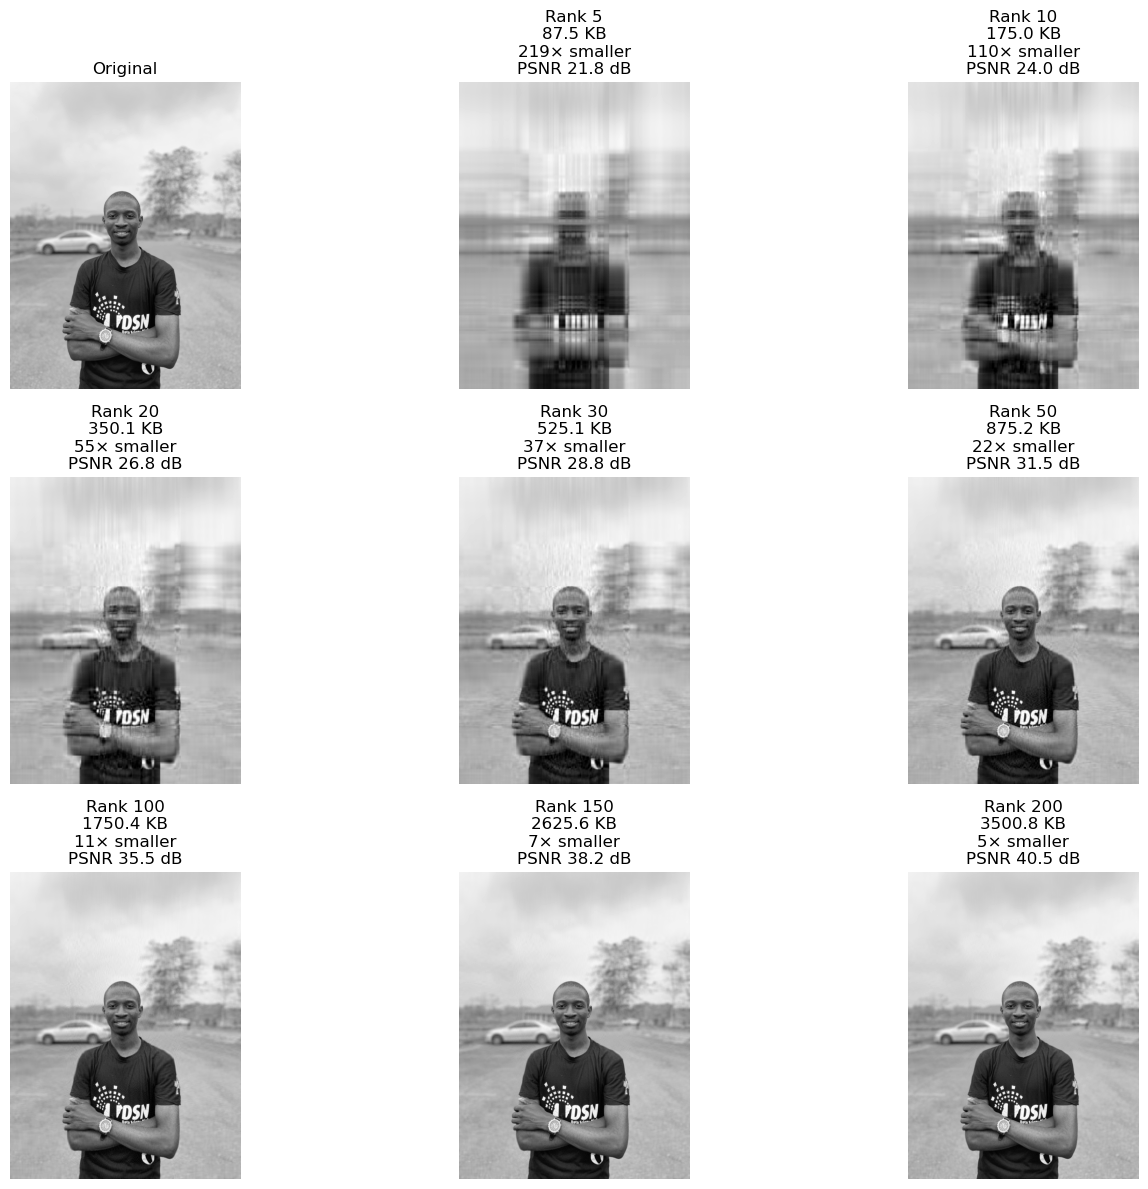

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

# Original image reference
axes[0].imshow(image_array, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")



for idx, k in enumerate(ranks_to_test[1:], start=1):
    if idx >= len(axes):
        break

    # Rebuild the image using only the first k singular components
    reconstructed = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]

    total_values, total_bytes = svd_storage(k, m, n, BYTES_PER_VALUE)
    compression_ratio = original_raw_bytes / total_bytes

    mse = np.mean((image_array - reconstructed) ** 2)
    psnr = 10 * np.log10(1.0 / mse) if mse > 0 else float("inf")
    energy = np.sum(S[:k] ** 2) / np.sum(S ** 2)

    axes[idx].imshow(np.clip(reconstructed, 0, 1), cmap="gray")
    axes[idx].set_title(
        f"Rank {k}\n"
        f"{total_bytes/1024:.1f} KB\n"
        f"{round(compression_ratio)}× smaller\n"
        f"PSNR {psnr:.1f} dB"
    )
    axes[idx].axis("off")

    print(f"Rank {k:3d} | "
          f"Storage: {total_bytes/1024:6.1f} KB | "
          f"Compression: {compression_ratio:5.1f}× | "
          f"Energy kept: {energy:6.2%} | "
          f"PSNR: {psnr:5.1f} dB")

plt.tight_layout()
plt.show()


## Rate-Distortion Analysis

Plot a rate-distortion curve showing how image quality (measured by PSNR) improves as we increase storage requirements. This helps visualize the trade-off between compression and quality.


In [21]:
# Rate–distortion view: how quality improves as we spend more storage
storage_kb = []
psnr_values = []

ranks = list(range(1, min(m, n), max(1, min(m, n) // 20)))

for k in ranks[:50]:
    _, total_bytes = svd_storage(k, m, n, BYTES_PER_VALUE)
    reconstructed = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]
    mse = np.mean((image_array - reconstructed) ** 2)

    psnr = 10 * np.log10(1.0 / mse) if mse > 0 else float("inf")

    storage_kb.append(total_bytes / 1024)
    psnr_values.append(min(psnr, 100))


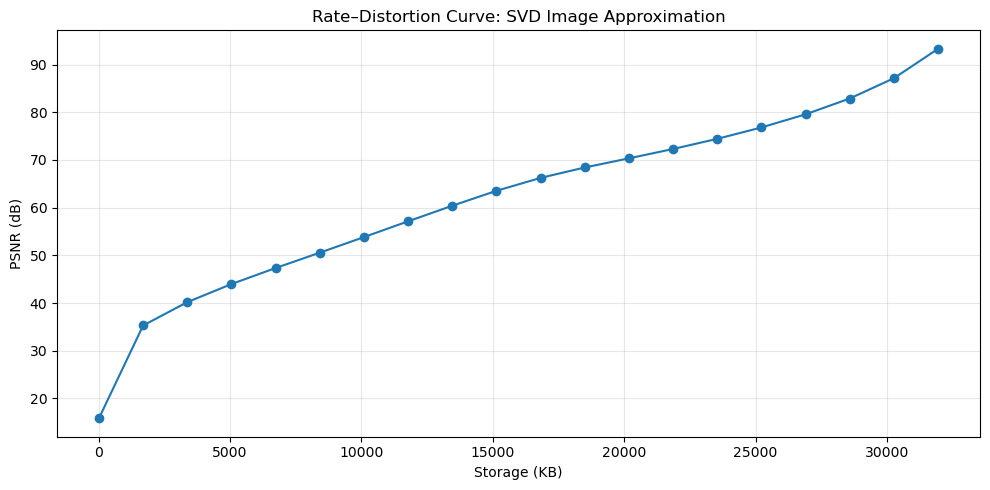

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(storage_kb, psnr_values, marker="o")
plt.xlabel("Storage (KB)")
plt.ylabel("PSNR (dB)")
plt.title("Rate–Distortion Curve: SVD Image Approximation")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
